This notebook takes borehole data from the East Kimberley and uses it to calculate the cementation values for solving Archie's Law.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils import points2convex_hull
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon
import aseg_gdf2

In [3]:
# Function for finding the nearest point 

def get_bore(df, borehole_id):
    """
    df: dataframe with borehole data
    borehole_id: eno
    
    returns
    dataframe with only rows corresponding to particular bore
    """
    mask = df['borehole_id'] == borehole_id
    return df[mask]


In [31]:
# First we want to open the rjmcmc aseg gdf file


infile = r"C:\Users\PCUser\Desktop\EK_data\AEM\garjmcmcmtdem\run2\output\lines\rjmcmc"

gdf = aseg_gdf2.read(infile).df()

In [62]:
# Now we want to link every sounding to a .mat file containing a larger number of the results

indir = r'C:\Users\PCUser\Desktop\EK_data\AEM\garjmcmcmtdem\run2\output\matlab_files'

gdf['pmap_path'] = ''

for index, row in gdf.iterrows():
    fname = '.'.join(['seq', "{:08d}".format(row['uniqueid ']), str(row['line ']), "{:.6f}".format(row['fiducial ']), 'mat'])
    outfile = os.path.join(indir, fname)
    assert os.path.exists(outfile)
    gdf.at[index, 'pmap_path'] = outfile
    
    

In [179]:
from scipy.io import loadmat

fname = r"C:\Users\PCUser\Desktop\EK_data\AEM\garjmcmcmtdem\run2\output\matlab_files\seq.00000069.312701.4930757.000000.mat"
x = loadmat(fname)

In [180]:
x['M'].dtype

dtype([('binfile', 'O'), ('comment', 'O'), ('flightnumber', 'O'), ('linenumber', 'O'), ('fidnumber', 'O'), ('easting', 'O'), ('northing', 'O'), ('ndata', 'O'), ('starttime', 'O'), ('endtime', 'O'), ('samplingtime', 'O'), ('nchain', 'O'), ('nsample', 'O'), ('nburnin', 'O'), ('nnuisance', 'O'), ('nl_min', 'O'), ('nl_max', 'O'), ('p_param', 'O'), ('pmin', 'O'), ('pmax', 'O'), ('npcells', 'O'), ('v_param', 'O'), ('vmin', 'O'), ('vmax', 'O'), ('nvcells', 'O'), ('sd_v', 'O'), ('sd_p', 'O'), ('sd_bd_v', 'O'), ('ar_birth', 'O'), ('ar_death', 'O'), ('ar_value', 'O'), ('ar_move', 'O'), ('ar_nuisance', 'O'), ('lhist', 'O'), ('cp', 'O'), ('f', 'O'), ('conv', 'O')])

In [181]:
for item in x['M']['conv'][0][0]['misfit'][0]:
    print(np.min(item))

25.575639724731445
28.04553985595703
116.92145538330078
435.27825927734375
111.2862548828125
440.2903747558594
25.369754791259766
112.92562866210938
439.53033447265625
25.484651565551758
437.7369689941406
442.8216857910156
444.0029296875
435.36810302734375
444.4163818359375
440.4059143066406
111.92581176757812
108.8175048828125
113.25830078125
26.38267707824707
110.42777252197266
440.16461181640625
442.24530029296875
437.1007995605469
441.6354675292969
111.61568450927734
439.1378479003906
441.7367248535156
440.01507568359375
113.99999237060547
441.1898498535156
24.74517250061035


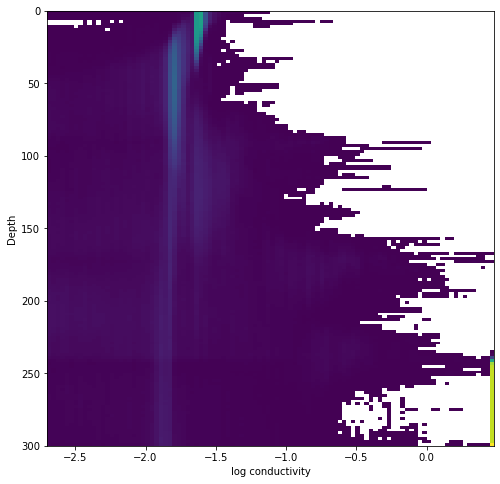

In [189]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

prob_plot = x['M']['f'][0][0]

prob_plot[prob_plot == 0.] = np.nan

vmin, vmax = x['M']['vmin'][0][0][0][0], x['M']['vmax'][0][0][0][0]
pmin, pmax = x['M']['pmin'][0][0][0][0], x['M']['pmax'][0][0][0][0]

ax.imshow(prob_plot, aspect = 'auto' ,extent = [vmin, vmax, pmax, pmin])
ax.set_xlabel('log conductivity')
ax.set_ylabel('Depth')
plt.show()

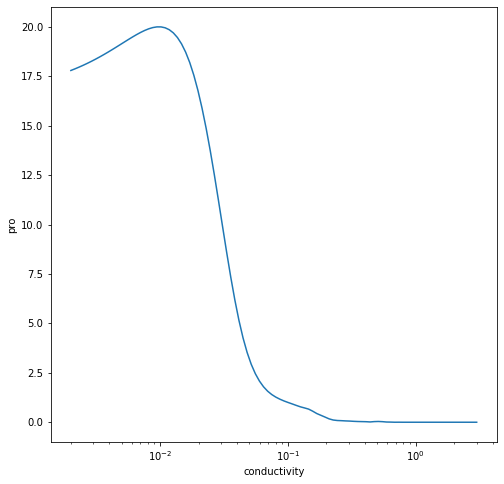

In [192]:
from scipy.stats import gaussian_kde

data = []
cond = 10**np.linspace(vmin, vmax, 100)
freq = prob_plot[100]


for i in range(freq.shape[0]):
    if not np.isnan(freq[i]):
        data.append([cond[i]]*int(freq[i]))

import itertools
# Flatten the data
data  = np.array(list(itertools.chain(*data)))

data = np.array(data).flatten()
density = gaussian_kde(data)

density.covariance_factor = lambda : .25
density._compute_covariance()

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.plot(cond,density(cond))
ax.set_xscale('log')
ax.set_ylabel('probability')
ax.set_xlabel('conductivity')
plt.show()

In [70]:
# Todo get a better polygon
Keep_poly = 'POLYGON ((497703.0000000027 8246242.49994433, 497669.0000000026 8246242.99994433, 497635.8125000035 8246246.49994433, 497603.4062500036 8246253.999944331, 496786.3125000036 8246526.499944339, 464605.5000000424 8257490.999944661, 466221.6875000397 8304389.499946042, 466469.6875000387 8305081.999946062, 488233.6875000138 8330164.999946804, 491461.4062500101 8333382.4999469, 523230.3124999756 8360782.999947714, 550185.3749999455 8350756.499947417, 554398.812499941 8345955.999947274, 565480.3749999278 8329967.999946802, 565481.374999927 8329943.4999468, 560532.9999999315 8318658.499946466, 497768.9062499999 8246255.499944331, 497736.5937500015 8246246.49994433, 497703.0000000027 8246242.49994433))'

In [71]:
# Extract data from the database

# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

SPATIALITE_PATH = r'C:\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)


connection = makeCon(DB_PATH)



Connected to C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [72]:
# Extract boreholes from within this geometry

df_header = borehole_utils.extract_boreholes_within_geometry('borehole', connection,
                                                             Keep_poly, columns = 'all',
                                                             verbose = True)
# Keep only bores with both EC and induction

mask = np.logical_and(df_header['Induction_acquired'] == 1,  df_header['EC_pH_acquired'] == 1)

df_header= df_header[mask]

# Get the enos



enos= df_header['borehole_id'].values


Select b.* from borehole b  where within(b.geom,GeomFromText('POLYGON ((497703.0000000027 8246242.49994433, 497669.0000000026 8246242.99994433, 497635.8125000035 8246246.49994433, 497603.4062500036 8246253.999944331, 496786.3125000036 8246526.499944339, 464605.5000000424 8257490.999944661, 466221.6875000397 8304389.499946042, 466469.6875000387 8305081.999946062, 488233.6875000138 8330164.999946804, 491461.4062500101 8333382.4999469, 523230.3124999756 8360782.999947714, 550185.3749999455 8350756.499947417, 554398.812499941 8345955.999947274, 565480.3749999278 8329967.999946802, 565481.374999927 8329943.4999468, 560532.9999999315 8318658.499946466, 497768.9062499999 8246255.499944331, 497736.5937500015 8246246.49994433, 497703.0000000027 8246242.49994433))'));


In [74]:
# First import all the datasets based on our enos (primary key)


df_EC = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'borehole_id'],
                                                       connection, enos, verbose = True)


select t.Depth, t.EC, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635921);


In [78]:
aem_coords = gdf[['easting ', 'northing ']].values

# Extract the AEM conductivity using nearest neighbour
distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          aem_coords,
                                                          points_required = 1,# return 10 closest points
                                                          max_distance = 250.)

In [196]:
df_header.shape


(13, 18)

In [194]:
# For every EC value we want to get the histogram of AEM conductivity binned in the log space

df_EC['EC']

0      1.5870
1      1.4620
2      1.2970
3      2.0450
4      2.1500
        ...  
652    0.4210
653    0.3912
654    0.3798
655    0.3822
656       NaN
Name: EC, Length: 657, dtype: float64

In [23]:
# Create an AEM dataframe

df_AEM = pd.DataFrame(columns = ['Depth_from', 'Depth_to',
                                 'conductivity', 'easting',
                                 'northing', 'borehole_id', 'EC',
                                 'doi'])

df_AEM['conductivity'] = conductivity_profile.flatten()
df_AEM['Depth_from'] = depth_tops.flatten()
df_AEM['Depth_to'] = depth_bottom.flatten()

df_AEM['easting'] = np.repeat(east, conductivity_profile.shape[1])
df_AEM['northing'] = np.repeat(north, conductivity_profile.shape[1])

df_AEM['doi'] = np.repeat(doi, conductivity_profile.shape[1])

df_AEM['borehole_id'] = np.repeat(df_header['borehole_id'].values,
                                   conductivity_profile.shape[1])

In [24]:
mask = df_AEM['doi'] > df_AEM['Depth_from']

In [25]:
df_AEM = df_AEM[mask]

In [26]:
df_AEM

,Depth_from,Depth_to,conductivity,easting,northing,borehole_id,EC,doi
0,0.000000,3.000000,0.178667,520112.68750,8306273.5,635728,NaN,89.919998
1,3.000000,6.300000,0.290192,520112.68750,8306273.5,635728,NaN,89.919998
2,6.300000,10.000000,0.848896,520112.68750,8306273.5,635728,NaN,89.919998
3,10.000000,14.100000,0.671141,520112.68750,8306273.5,635728,NaN,89.919998
4,14.100000,18.600000,0.712758,520112.68750,8306273.5,635728,NaN,89.919998
5,18.600000,23.600000,0.846024,520112.68750,8306273.5,635728,NaN,89.919998
6,23.600000,29.100000,0.843882,520112.68750,8306273.5,635728,NaN,89.919998
7,29.100000,35.200001,0.718907,520112.68750,8306273.5,635728,NaN,89.919998
8,35.200001,41.900002,0.546150,520112.68750,8306273.5,635728,NaN,89.919998
9,41.900002,49.299999,0.400160,520112.68750,8306273.5,635728,NaN,89.919998


In [27]:
# Now we iterate through each column and find the average

for bore in df_AEM['borehole_id'].unique():
    
    df_EC_subset = get_bore(df_EC, bore)
    
    df_AEM_subset = get_bore(df_AEM, bore)
    
    new_intervals = df_AEM_subset[['Depth_from', 'Depth_to']]
    
    
    df_newEC = spatial_functions.interpolate_depths_to_intervals(df_EC_subset, ['EC'],
                                                                 new_intervals.values,
                                                                depth_column='Depth', how='median')

    df_AEM_subset['EC'] = df_newEC['EC'].values
    
    df_AEM.at[df_AEM_subset.index, :] = df_AEM_subset
    
    
df_AEM.dropna(how = 'any', subset = ['EC'], inplace=True)

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [28]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df_AEM['conductivity'].values),
                                                               np.log10(df_AEM['EC'].astype(np.float).values))

R-squared =  0.8674041106281604
EC =  0.9060561444524374  * sigma +  0.4937600070627951


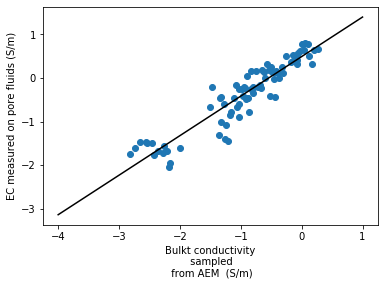

In [29]:
# Scatter plot the EC and apparent conductivity

x = np.array([-4,1])
y = slope * x + intercept
        
plt.plot(x, y, 'k')

plt.scatter(np.log10(df_AEM['conductivity'].values),
           np.log10(df_AEM['EC'].astype(np.float).values))
           #c = df_EC_cond['Depth'].values,
           #colormap='viridis')
print('R-squared = ', str(r_value**2))
print('EC = ', str(slope), ' * sigma + ', str(intercept) )

        
plt.xlabel('Bulkt conductivity\n sampled\n from AEM  (S/m)')

plt.ylabel('EC measured on pore fluids (S/m)')

plt.savefig(r'C:\Temp\EK_EC_AEM_conductivity.png', dpi = 300)
plt.show()

In [23]:
cz_base_src = rasterio.open(infile)
cz_base_arr = cz_base_src.read()[0]

(68,)

In [25]:
slope


0.809932865164502